# Context

`TODO`

# Question
How closely has the unsheltered homelessness count performed by the Downtown San Diego Partnership correlated to precipitation?

# Datasets

## Downtown San Diego Unsheltered Count
- Link to the dataset: [downtownsandiego.org](https://downtownsandiego.org/clean-and-safe/unhoused-care/) [(pdf)](https://downtownsandiego.org/wp-content/uploads/2024/03/February-2024-Unsheltered-Count-w-Maps.pdf)
- Number of observations: 146 (12 months * 12 years + 2 months)
- Number of variables: 2 (date, count)

This dataset contains monthly counts of unsheltered people performed by the Downtown San Diego Partnership using the Clean & Safe Program methodology. The `.pdf` was converted to `.csv` by hand.

## Downtown San Diego Precipitation
- Link to the dataset: generated from [scacis.rcc-acis.org](https://scacis.rcc-acis.org/)
- Number of observations: 146 (12 months * 12 years + 2 months)
- Number of variables: 2 (date, precipitation)

This dataset contains the monthly sum of precipitation (in inches of water) January 2012 to March 2024, measured at the San Diego International Airport weather station. This acts as a proxy for the precipitation experienced across the rest of Downtown San Diego.

# Setup

In [51]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import math

# data
def fetchMeltMerge(csv, id, var, value, data):
  newData = pd.read_csv(csv, skipinitialspace=True)
  newMelt = pd.melt(newData, id_vars=[id], var_name=var, value_name=value)
  
  if data.empty:
    return newMelt
  else:
    return pd.merge(data, newMelt, on=[id, var], how='outer')
  
# visualization
plt.rcParams['figure.figsize'] = (16, 8)
uhc = "Unsheltered Homeless Count"

def noLabels():
  plt.xlabel(" ")
  plt.ylabel(" ")

In [52]:
# dataName, dataLocation
dataFiles = [
  ('uhc', 'adata/dt_sd_unsheltered_count.csv'),
  ('precip', 'adata/sd_precip_92101.csv')
]

# create an empty frame to populate
df = pd.DataFrame()

# pull in all the data
for dataName, dataLocation in dataFiles:
  df = fetchMeltMerge(dataLocation, 'Year', 'Month', dataName, df)

# do some cleaning up
monthToNumber = {
    'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
    'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12
}

df['Month'].replace(monthToNumber, inplace=True)
df = df.sort_values(by=['Year', 'Month']).reset_index(drop=True)
df.rename(columns={'Month':'month', 'Year':'year'}, inplace=True)

# Introduction

In [53]:
df.iloc[:,2:].describe()[1:]

,uhc,precip
mean,912.294521,0.790616
std,364.987825,1.168362
min,405.000000,0.000000
25%,634.500000,0.010000
50%,801.500000,0.255000
75%,1128.500000,1.007500
max,2104.000000,5.140000


An initial key takeaway is the wide range for both variables, namely the gap between `min` and `max` in light of the mean for both. 

- The disparity in `uhc` is confounded by the dramatic increase in homelessness following COVID. 
- Precipitation's variation is driven by how frequently San Diego goes without rain paired with infrequent tropical storms.

Using rolling values for both is important to offsetting these effects. Further, a rolling value for `precip` makes sense because a continuous rainy period is more likely to lead an unsheltered person acquire/use a structure such as a tent. That would in turn drive up `uhc`, as the Clean & Safe Program treats structures like tents as 2 people. Similarly, a rolling value for `uhc` reduces noise inherent to the imperfect counting system.

For `uhc`, I'll use a mean with a 3 month window.  
For `precip`, the same window, but a sum.   

In [54]:
df['roll3precip'] = df['precip'].rolling(3, min_periods=3).sum()

df['roll3uhc'] = df['uhc'].rolling(3, min_periods=3, center=False).mean()

# Using a rolling window will create `NaN` values for the first 2 periods, so
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

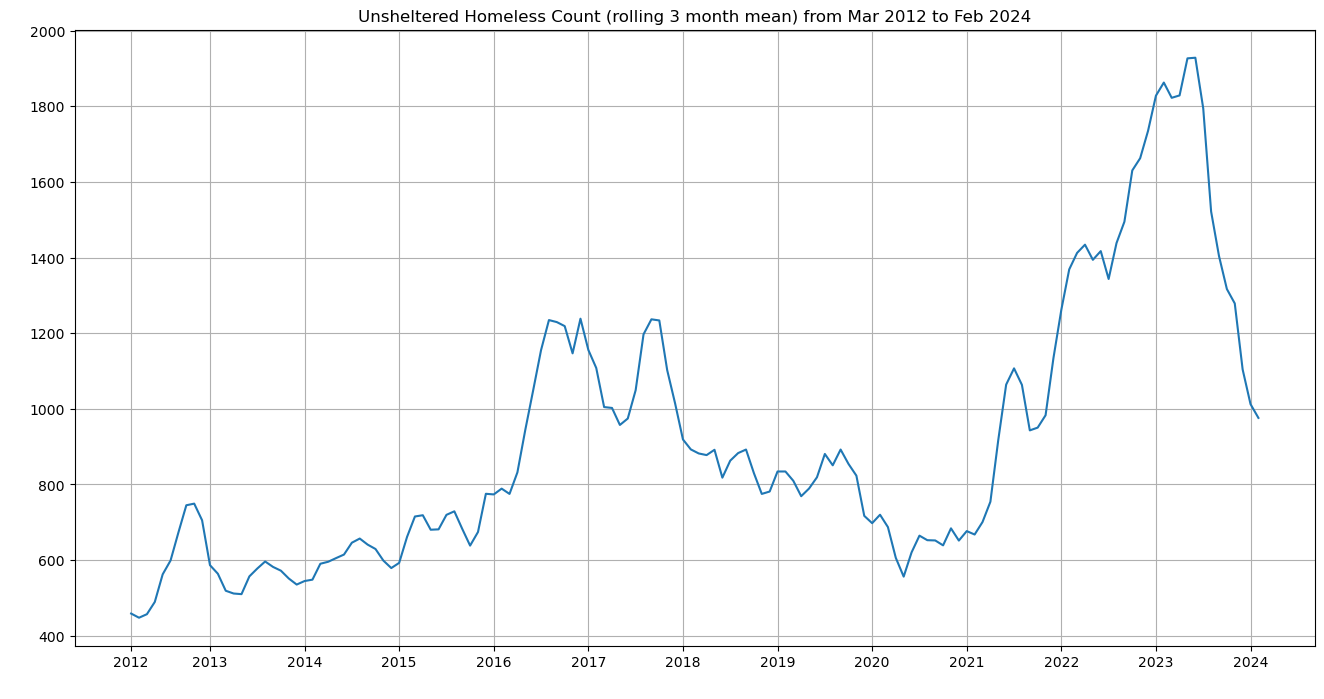

In [7]:
yearChangeIndices = df['year'].diff().ne(0).to_numpy().nonzero()[0]
plt.xticks(ticks=yearChangeIndices, labels=df.loc[yearChangeIndices, 'year'])
plt.title(f"{uhc} (rolling 3 month mean) from Mar 2012 to Feb 2024")
noLabels()
plt.grid()

sns.lineplot(data=df, x=df.index, y="roll3uhc")
plt.show()

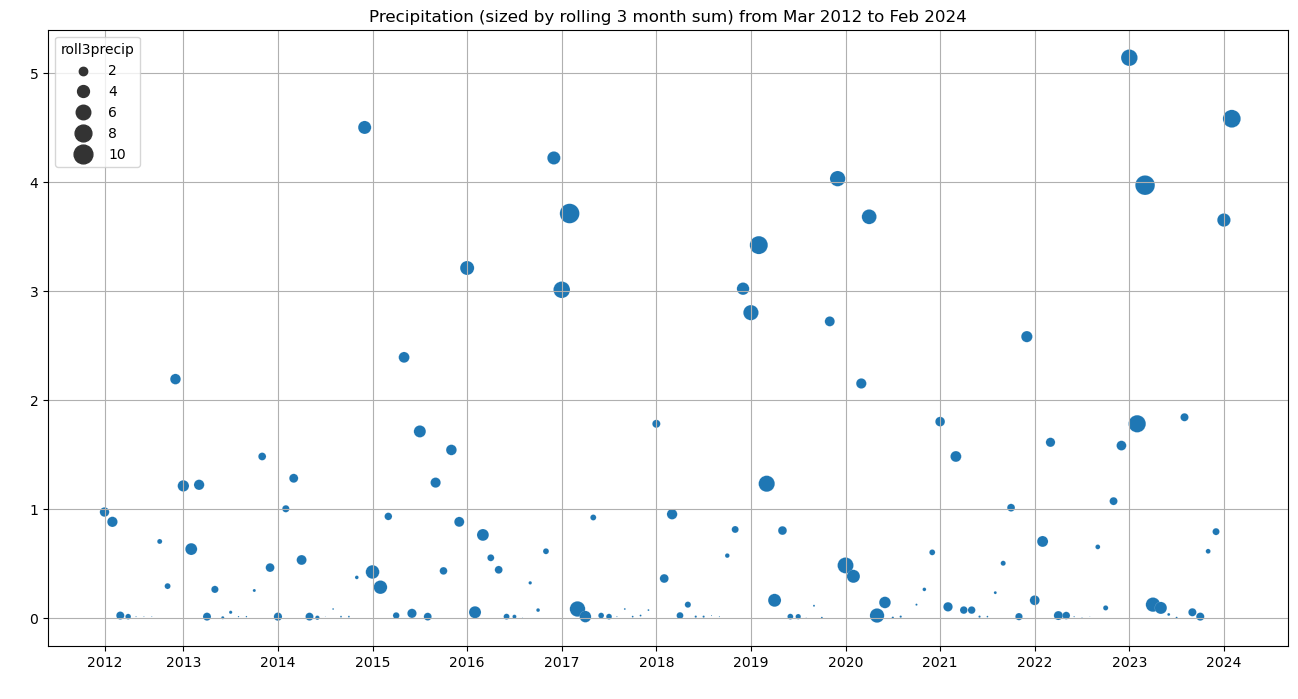

In [8]:
plt.xticks(ticks=yearChangeIndices, labels=df.loc[yearChangeIndices, 'year'])
plt.title(f"Precipitation (sized by rolling 3 month sum) from Mar 2012 to Feb 2024")
plt.grid()
noLabels()

sns.scatterplot(data=df, x=df.index, y="precip", size="roll3precip", sizes=(0, 200))
plt.show()

The largest peaks in the rolling unsheltered count appear to correspond with high periods of precipitation.

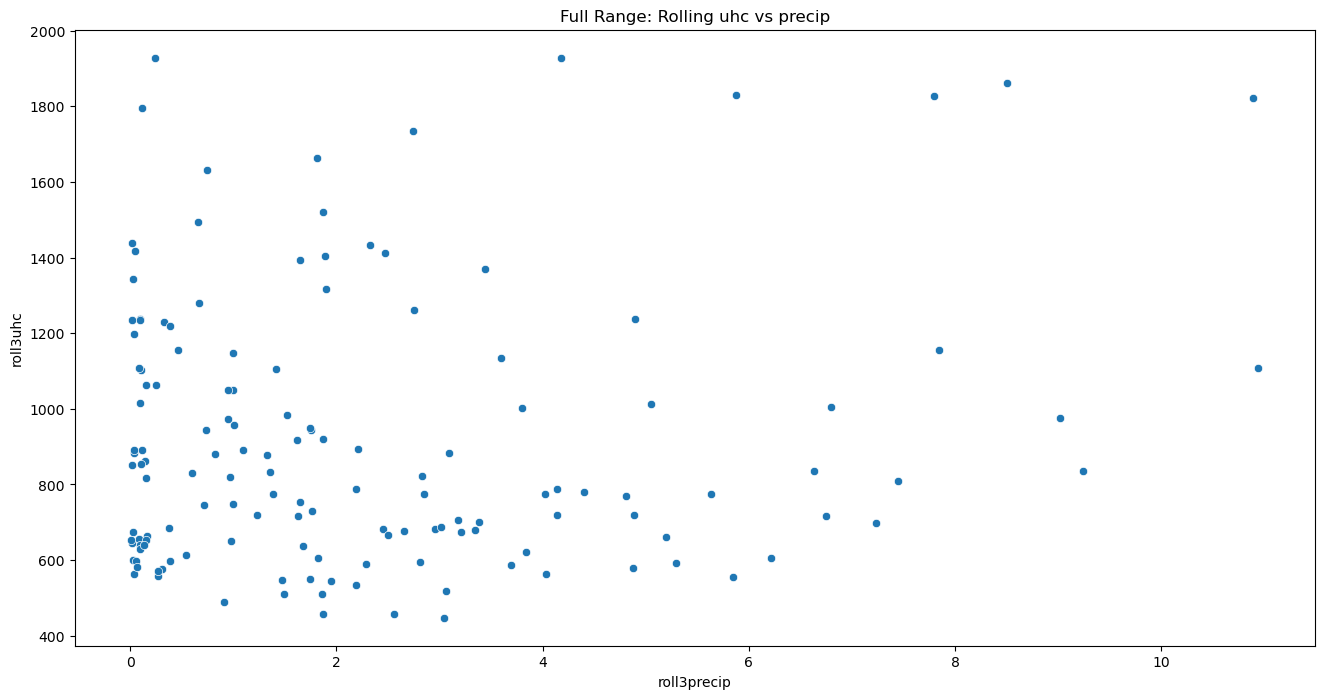

In [9]:
sns.scatterplot(data=df, y='roll3uhc', x="roll3precip")
plt.title("Full Range: Rolling uhc vs precip")
plt.show()

One issue is the large amount of nil precipitation values (as indicted in the initial distribution numbers).

# Analyses

In [10]:
import statsmodels.formula.api as smf
import numpy as np

model = lambda df: smf.ols(data=df, formula="roll3uhc ~ roll3precip").fit()
t = lambda k: df[df['roll3precip'] > k]

The Safe & Clean program counts tent structures as a multiple (1.75 - 2.03) of people. This suggests a deriveable linear relationship. Using the intuition from earlier, let's examine thresholds for accumulated precipitation.

In [ ]:
models = []
for k in range(0, 5 * 4):
    k *= 0.2
    models.append(model(t(k)))

In [ ]:
modelsR2, modelsAIC = zip(*[(m.rsquared, m.aic) for m in models])
maxR2k = max(enumerate(modelsR2), key=lambda x:x[1])[0]

sns.scatterplot(data=t(k), y='roll3uhc', x="roll3precip")
plt.title("Rolling uhc vs threshold {k*0.2} inches rolling precip")
plt.show()

In [ ]:
models[maxR2k].summary()

# Limitations

The greatest limitation to this analysis is the incredible amount of confounding variable possibilities. COVID  unemployment being an obvious one, but another is the varying political landscape in San Diego, namely efforts to displace and destroy homeless structures in Downtown.  Further, by using a threshold for periods with higher accumulated precipitation, I constrain the data set to a smaller size (only ~30% of the full range, 46 observations).